In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [ ]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.3/356.3 kB 16.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.1-py2.py3-none-any.whl size=351210 sha256=f6b4c04e03821b09419c64605e315e4b7759f25c33963ee9cda6af60a1490df1
  Stored in directory: /root/.cache/pip/wheels/51/92/44/e2ef13f803aa08711819357e6de0c5fe67b874671141413565
Successfully built emoji


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import emoji

from sklearn.feature_extraction.text import TfidfVectorizer

from imblearn.over_sampling import SMOTE

import re

In [ ]:
# Load data

train_small = pd.read_csv("/content/drive/MyDrive/tulu/tulu-train.csv")
dev_df = pd.read_csv("/content/drive/MyDrive/tulu/tulu-dev.csv")
train_df = train_small.append(dev_df, ignore_index = True)
test_df = pd.read_csv("/content/drive/MyDrive/tulu/sen_tulu_test_with_label.csv")

<ipython-input-4-9ee0dda65759>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_small.append(dev_df, ignore_index = True)


In [1]:
#IMPORT FROM LIST
#DUMMY NOW

synonyms =[]

[Text(0, 0, '3487'), Text(0, 0, '1921'), Text(0, 0, '1094'), Text(0, 0, '736')]

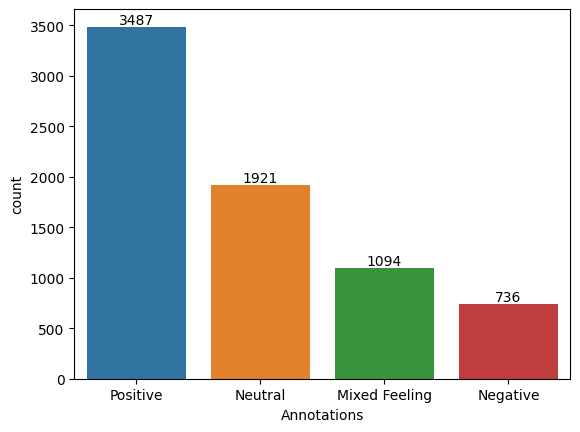

In [ ]:
# Create the plot
ax = sns.countplot(x=train_df['Annotations'])
ax.bar_label(ax.containers[0], label_type='edge')

# plt.xlabel("Category")
# plt.ylabel("Frequency")

# plt.show()

[Text(0, 0, '344'), Text(0, 0, '197'), Text(0, 0, '60'), Text(0, 0, '107')]

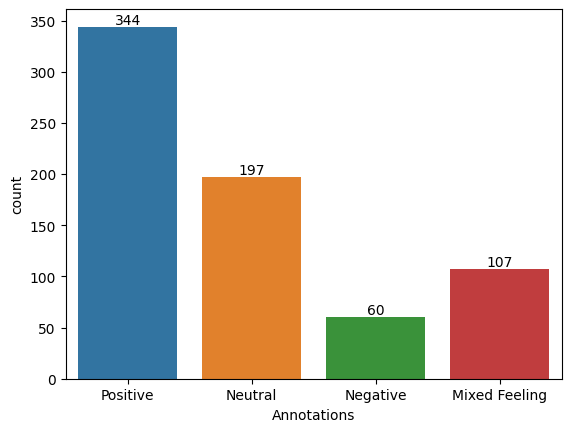

In [ ]:
ax = sns.countplot(x=test_df['Annotations'])
ax.bar_label(ax.containers[0], label_type='edge')

Preprocess Emojis

In [ ]:
# Outright removing emojis reduces performancet
def process_emojis(df_col):
  deemojised_text = []

  for row in df_col:
    #deemojised_text.append(emoji.demojize(''.join(('') if c in emoji.EMOJI_DATA else c for c in row)))
    deemojised_text.append(emoji.demojize(''.join((' '+c+' ') if c in emoji.EMOJI_DATA else c for c in row)))

  return deemojised_text

Remove punctuation, special characters, numbers, tags, URLs

In [ ]:
def clean_text(df_col):
    cleaned_text = []

    for text in df_col:
      # Remove HTML tags
      text = re.sub(r'<[^>]+>', '', text)
      # Remove URLs
      text = re.sub(r'http\S+', '', text)
      # Remove punctuation and special characters
      text = re.sub(r'[^\w\s]', ' ', text)
      # Remove numbers
      text = re.sub(r'\d+', '', text)
      # Remove extra whitespaces
      text = re.sub(r'\s+', ' ', text).strip()
      text = text.lower()
      cleaned_text.append(text)

    #print(cleaned_text)
    return cleaned_text

Remove stopwords

Note: This reduced the model performace

In [ ]:
path = "/content/drive/MyDrive/tulu/eng_tulu_stopwords.txt"

stopwords = set()
with open(path) as f:
  for line in f:
    for word in (line.rstrip().split(', ')):
      stopwords.add(word)

In [ ]:
def remove_stopwords(df_col):
    stop_removed = []

    for text in df_col:
      stop_removed.append(' '.join([word for word in text.split() if word.lower() not in stopwords]))

    return stop_removed
    #return df_col

Remove entries with non-English chars

Note: This reduces model performance

In [ ]:
# Search compeletely English chars text
# Drop the rows other rows

def eng_chars_rows(df_col):
  def isEnglish(s):
    return any(ord(c) > 127 for c in s)
  is_eng = []

  for row in df_col:
    is_eng.append(not isEnglish(row))

  return is_eng

In [ ]:
# Comments consisting less than 3 words and longer than
# 15 words were removed as it is difficult to comprehend
# the sentiments

def check_len(df_col):
  l = []
  for i in (df_col):
    if len(i.split()) >= 3 and len(i.split()) <= 15:
      l.append(1)
    else:
      l.append(0)

  return l


In [ ]:
# Encode all
# train_df = ordinal_encoder(orig_train_df, orig_train_df.drop(['Text'], axis=1).columns)
# test_df = ordinal_encoder(orig_test_df, orig_test_df.drop(['Text'], axis=1).columns)


In [ ]:
# Apply all preprocessing to Text
train_df['Processed_Text'] = process_emojis(train_df['Text'])
train_df['Processed_Text'] = clean_text(train_df['Processed_Text'])
#train_df['Processed_Text'] = remove_stopwords(train_df['Processed_Text'])

test_df['Processed_Text'] = process_emojis(test_df['Text'])
test_df['Processed_Text'] = clean_text(test_df['Processed_Text'])
#test_df['Processed_Text'] = remove_stopwords(test_df['Processed_Text'])

In [ ]:
train_df['Is_Eng'] = eng_chars_rows(train_df['Processed_Text'])
train_df = train_df[train_df['Is_Eng'] == True]

test_df['Is_Eng'] = eng_chars_rows(test_df['Processed_Text'])
test_df = test_df[test_df['Is_Eng'] == True]

In [ ]:
train_df['Len'] = check_len(train_df['Processed_Text'])
train_df = train_df[train_df['Len'] == 1]

test_df['Len'] = check_len(test_df['Processed_Text'])
test_df = test_df[test_df['Len'] == 1]


In [ ]:
train_df

,Text,Annotations,Processed_Text,Is_Eng,Len
0,Devdas kapikad no1,Positive,devdas kapikad no,True,1
1,ajji eer super,Positive,ajji eer super,True,1
2,Bega 2 nd part padle,Neutral,bega nd part padle,True,1
4,Tulu panda enku masth ista i love tulu tulunadu,Positive,tulu panda enku masth ista i love tulu tulunadu,True,1
5,Vlog ista apundu masth and ir patherniya kendr...,Positive,vlog ista apundu masth and ir patherniya kendr...,True,1
...,...,...,...,...,...
7233,SUPERB ALL ARE ACTING....AMAZING...BHARI KUSH...,Positive,superb all are acting amazing bhari kushi aand...,True,1
7234,Bolar anna sooooopar..,Positive,bolar anna sooooopar,True,1
7235,.. question onji..\nKai yereeeg mugiyondh ethin🥺😥,Neutral,question onji kai yereeeg mugiyondh ethin plea...,True,1
7236,Extra pukuli ethenakulu... Ayeg korle... Plz,Positive,extra pukuli ethenakulu ayeg korle plz,True,1


In [ ]:
test_df

,Text,Annotations,Processed_Text,Is_Eng,Len
0,Suraaj shetr eer manjeswaradaara wow yanla alp...,Positive,suraaj shetr eer manjeswaradaara wow yanla alp...,True,1
1,Bari Porluda Comedy Show,Positive,bari porluda comedy show,True,1
2,"Att marayere.\nAde Al-Cafe dalpa, Somosa Ajjer...",Neutral,att marayere ade al cafe dalpa somosa ajjereg ...,True,1
3,Embe onji mage karmda,Negative,embe onji mage karmda,True,1
4,bari porlu😘tulunad namma☺,Positive,bari porlu face_blowing_a_kiss tulunad namma s...,True,1
...,...,...,...,...,...
702,Ice cream da price yth?,Neutral,ice cream da price yth,True,1
703,NINNA APPE BANG KORPUNO,Neutral,ninna appe bang korpuno,True,1
704,Bhagavather edde uller,Positive,bhagavather edde uller,True,1
705,Dinesh Sir ...yedde msg korthar ...masth kushi...,Positive,dinesh sir yedde msg korthar masth kushi aapun...,True,1


In [ ]:
import pandas as pd

# Assuming `series` is your Pandas Series containing the words
series = train_df['Processed_Text']
result = synonyms
for sublist in result:
    sublist_words = sublist[1]
    first_word = sublist[0]

    # Create a boolean mask for words in the sublist
    mask = series.apply(lambda x: any(word in sublist_words for word in x.split()))

    # Replace the words in the mask with the first word from the sublist
    series.loc[mask] = series.loc[mask].apply(lambda x: ' '.join([first_word if word in sublist_words else word for word in x.split()]))

# Print the updated Series
print(series)

<ipython-input-19-f7680ace5048>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[mask] = series.loc[mask].apply(lambda x: ' '.join([first_word if word in sublist_words else word for word in x.split()]))


0                                       devdas kapikad no
1                                          ajji eer super
2                                      bega nd part padle
4          tulu panda enku masth ista i love tulu tulunad
5       vlog ista apund masth and eer patherniya kendr...
                              ...                        
7233    super all are acting amazing bhari kushi aand ...
7234                                 bolar anna sooooopar
7235    question onji kai yereeeg mugiyondh ethin plea...
7236              extra pukilin ethenakulu ayna korle plz
7237                mattuda ponne eer guttu yan tinondene
Name: Processed_Text, Length: 6264, dtype: object


In [ ]:
import pandas as pd

# Assuming `series` is your Pandas Series containing the words
series = test_df['Processed_Text']
result = synonyms
for sublist in result:
    sublist_words = sublist[1]
    first_word = sublist[0]

    # Create a boolean mask for words in the sublist
    mask = series.apply(lambda x: any(word in sublist_words for word in x.split()))

    # Replace the words in the mask with the first word from the sublist
    series.loc[mask] = series.loc[mask].apply(lambda x: ' '.join([first_word if word in sublist_words else word for word in x.split()]))

# Print the updated Series
print(series)

0      suraaj shetr eer manjeswaradaara wow yan alpad...
1                               bari porluda comedy show
2      athnd marayere ade aal cafe dalpa somosa ajjer...
3                                  embe onji mage karmda
4      bari porlu face_blowing_a_kiss tulunad nama sm...
                             ...                        
702                               ice cream da price yth
703                                eer appe bang korpuno
704                              bhagavather yedde uller
705    dinesh sir yedde msg korthar masth kushi apund...
707                    kasargod tulu slang correct athnd
Name: Processed_Text, Length: 609, dtype: object


<ipython-input-20-1e59a8e48cdd>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[mask] = series.loc[mask].apply(lambda x: ' '.join([first_word if word in sublist_words else word for word in x.split()]))


TF-IDF

In [ ]:
X_train = train_df['Processed_Text']
y_train = train_df['Annotations']

X_test = test_df['Processed_Text']
y_test = test_df['Annotations']

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_train

array([3, 3, 2, ..., 2, 3, 2])

In [ ]:
y_test = le.fit_transform(y_test)
y_test

array([3, 3, 2, 1, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2,
       2, 3, 2, 3, 3, 3, 0, 3, 3, 3, 3, 2, 1, 3, 3, 0, 2, 1, 2, 1, 0, 2,
       3, 0, 3, 3, 2, 2, 2, 2, 3, 3, 0, 0, 2, 2, 3, 2, 3, 3, 2, 0, 0, 3,
       3, 0, 1, 0, 3, 0, 0, 3, 1, 3, 0, 3, 3, 2, 2, 0, 3, 2, 1, 2, 3, 3,
       3, 3, 3, 0, 2, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3,
       3, 0, 3, 3, 0, 3, 3, 3, 2, 0, 3, 0, 2, 0, 2, 3, 2, 0, 1, 1, 3, 0,
       3, 2, 2, 1, 2, 2, 3, 0, 1, 0, 3, 2, 3, 3, 0, 3, 3, 0, 2, 0, 0, 0,
       2, 3, 3, 3, 3, 3, 0, 2, 2, 0, 3, 2, 1, 1, 2, 2, 3, 0, 3, 0, 2, 3,
       2, 3, 3, 3, 0, 0, 1, 3, 2, 3, 2, 3, 3, 0, 3, 3, 2, 3, 3, 2, 0, 2,
       0, 3, 0, 0, 3, 3, 0, 2, 3, 2, 3, 1, 2, 3, 2, 2, 0, 3, 3, 2, 3, 2,
       3, 3, 3, 2, 3, 0, 3, 3, 0, 0, 3, 2, 2, 2, 3, 3, 3, 3, 0, 3, 0, 1,
       3, 2, 2, 2, 2, 3, 3, 1, 3, 2, 3, 2, 1, 2, 2, 2, 2, 2, 3, 3, 3, 1,
       1, 3, 2, 3, 3, 1, 1, 0, 2, 2, 3, 2, 3, 2, 2, 1, 3, 2, 1, 3, 2, 0,
       3, 2, 0, 3, 0, 2, 3, 3, 2, 1, 2, 2, 3, 2, 3,

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer= TfidfVectorizer(max_features=5000, ngram_range=(1, 2), use_idf=False)
tf_x_train = vectorizer.fit_transform(X_train)
tf_x_test = vectorizer.transform(X_test)


Upsampling


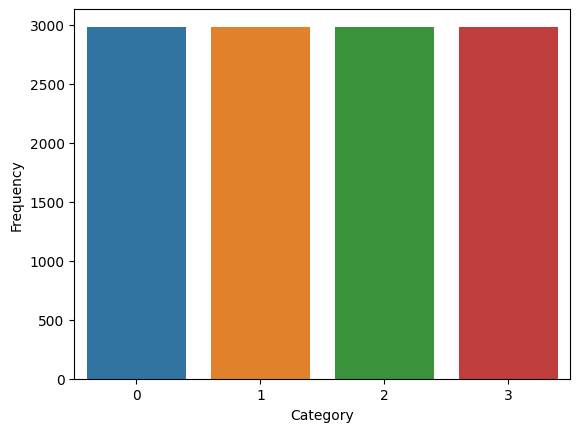

In [ ]:
# Apply SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(tf_x_train, y_train)

sns.countplot(x=y_train_resampled)

# Add labels to the plot
plt.xlabel("Category")
plt.ylabel("Frequency")

# Display the plot
plt.show()

# Data Augmentation

In [ ]:
!pip install textattack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.7/418.7 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 769.7/769.7 kB 62.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 95.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 101.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 MB 22.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.5/97

In [ ]:
from textattack.augmentation import EasyDataAugmenter
#from textattack.augmentation import CLAREAugmenter

textattack: Updating TextAttack package dependencies.
textattack: Downloading NLTK required packages.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw to /root/nltk_data...
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
train_df.reset_index(level=None, drop=True, inplace=True, col_level=0, col_fill='')
train_df

,Text,Annotations,Processed_Text,Is_Eng,Len
0,Devdas kapikad no1,Positive,devdas kapikad no,True,1
1,ajji eer super,Positive,ajji eer super,True,1
2,Bega 2 nd part padle,Neutral,bega nd part padle,True,1
3,Tulu panda enku masth ista i love tulu tulunadu,Positive,tulu panda enku masth ista i love tulu tulunad,True,1
4,Vlog ista apundu masth and ir patherniya kendr...,Positive,vlog ista apund masth and eer patherniya kendr...,True,1
...,...,...,...,...,...
6259,SUPERB ALL ARE ACTING....AMAZING...BHARI KUSH...,Positive,super all are acting amazing bhari kushi aand ...,True,1
6260,Bolar anna sooooopar..,Positive,bolar anna sooooopar,True,1
6261,.. question onji..\nKai yereeeg mugiyondh ethin🥺😥,Neutral,question onji kai yereeeg mugiyondh ethin plea...,True,1
6262,Extra pukuli ethenakulu... Ayeg korle... Plz,Positive,extra pukilin ethenakulu ayna korle plz,True,1


In [ ]:
def augment_text(df):
  aug_text = []
  eda_aug = EasyDataAugmenter()
  #eda_aug = CLAREAugmenter()
  for i, row in df.iterrows():
      mod = eda_aug.augment(row['Processed_Text'])
      annotation = row['Annotations']

      for j in mod:
        aug_text.append([j, annotation])

  return aug_text

aug_text = (augment_text(train_df))

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
len(aug_text)

23787

In [ ]:
augmented_train_df = pd.DataFrame(aug_text, columns = ['Processed_Text', 'Annotations'])
augmented_train_df

,Processed_Text,Annotations
0,devdas kapikad no,Positive
1,devdas kapikad nobelium no,Positive
2,kapikad devdas no,Positive
3,kapikad no,Positive
4,ajji eer superintendent,Positive
...,...,...
23782,extra ethenakulu ayna korle plz,Positive
23783,extra pukilin ethenakulu ayna korle plz,Positive
23784,mattuda ponne eer tinondene yan guttu,Neutral
23785,mattuda eer guttu yan tinondene,Neutral


In [ ]:
#insert new technique here

In [ ]:
X_train, X_test = augmented_train_df['Annotations'], test_df['Annotations']

In [ ]:
y_train= le.fit_transform(augmented_train_df['Annotations'])
y_train

array([3, 3, 3, ..., 2, 2, 2])

In [ ]:
print(X_train.shape, y_train.shape)

(23787,) (23787,)


In [ ]:
print(X_test.shape, y_test.shape)

(609,) (609,)


In [ ]:
y_test

array([3, 3, 2, 1, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2,
       2, 3, 2, 3, 3, 3, 0, 3, 3, 3, 3, 2, 1, 3, 3, 0, 2, 1, 2, 1, 0, 2,
       3, 0, 3, 3, 2, 2, 2, 2, 3, 3, 0, 0, 2, 2, 3, 2, 3, 3, 2, 0, 0, 3,
       3, 0, 1, 0, 3, 0, 0, 3, 1, 3, 0, 3, 3, 2, 2, 0, 3, 2, 1, 2, 3, 3,
       3, 3, 3, 0, 2, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3,
       3, 0, 3, 3, 0, 3, 3, 3, 2, 0, 3, 0, 2, 0, 2, 3, 2, 0, 1, 1, 3, 0,
       3, 2, 2, 1, 2, 2, 3, 0, 1, 0, 3, 2, 3, 3, 0, 3, 3, 0, 2, 0, 0, 0,
       2, 3, 3, 3, 3, 3, 0, 2, 2, 0, 3, 2, 1, 1, 2, 2, 3, 0, 3, 0, 2, 3,
       2, 3, 3, 3, 0, 0, 1, 3, 2, 3, 2, 3, 3, 0, 3, 3, 2, 3, 3, 2, 0, 2,
       0, 3, 0, 0, 3, 3, 0, 2, 3, 2, 3, 1, 2, 3, 2, 2, 0, 3, 3, 2, 3, 2,
       3, 3, 3, 2, 3, 0, 3, 3, 0, 0, 3, 2, 2, 2, 3, 3, 3, 3, 0, 3, 0, 1,
       3, 2, 2, 2, 2, 3, 3, 1, 3, 2, 3, 2, 1, 2, 2, 2, 2, 2, 3, 3, 3, 1,
       1, 3, 2, 3, 3, 1, 1, 0, 2, 2, 3, 2, 3, 2, 2, 1, 3, 2, 1, 3, 2, 0,
       3, 2, 0, 3, 0, 2, 3, 3, 2, 1, 2, 2, 3, 2, 3,

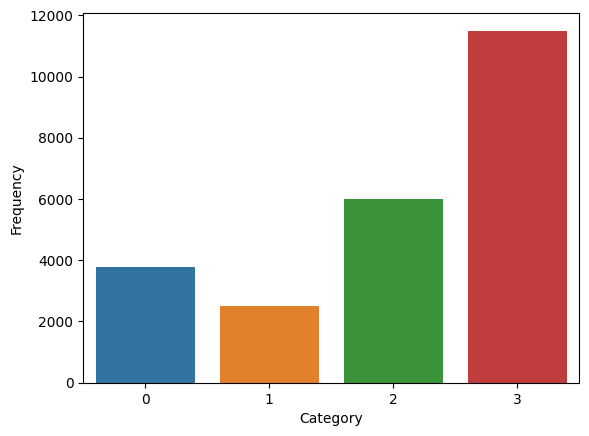

In [ ]:
sns.countplot(x=y_train)

# Add labels to the plot
plt.xlabel("Category")
plt.ylabel("Frequency")

# Display the plot
plt.show()

In [ ]:
tf_x_aug_train = vectorizer.transform(augmented_train_df['Processed_Text'])
y_aug_train = augmented_train_df['Annotations']
print(tf_x_train.shape, y_train.shape, tf_x_test.shape, y_test.shape )
print(tf_x_aug_train.shape, y_aug_train.shape)

(6264, 5000) (23787,) (609, 5000) (609,)
(23787, 5000) (23787,)


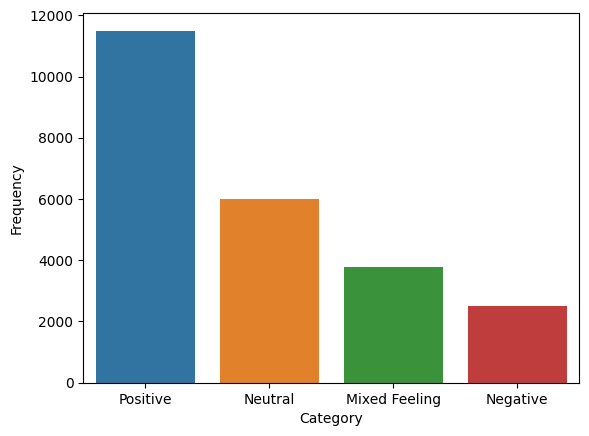

In [ ]:
sns.countplot(x=y_aug_train)

# Add labels to the plot
plt.xlabel("Category")
plt.ylabel("Frequency")

# Display the plot
plt.show()

(45988, 5000) (45988,)


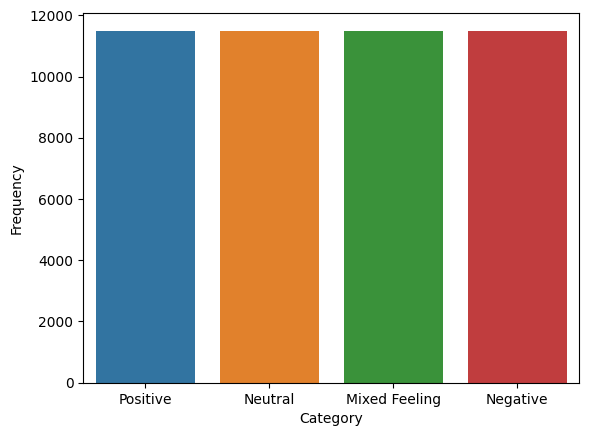

In [ ]:
smote = SMOTE()
X_train_aug_resampled, y_train_aug_resampled = smote.fit_resample(tf_x_aug_train, y_aug_train)
print(X_train_aug_resampled.shape, y_train_aug_resampled.shape)

sns.countplot(x=y_train_aug_resampled)

# Add labels to the plot
plt.xlabel("Category")
plt.ylabel("Frequency")

# Display the plot
plt.show()

In [ ]:
X_train_aug_resampled

<45988x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 257345 stored elements in Compressed Sparse Row format>

In [ ]:
y_train_aug_resampled = le.fit_transform(y_train_aug_resampled)
y_train_aug_resampled

array([3, 3, 3, ..., 2, 2, 2])

In [ ]:
tf_x_test

<609x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3154 stored elements in Compressed Sparse Row format>

In [ ]:
y_test

array([3, 3, 2, 1, 3, 2, 3, 3, 3, 2, 2, 3, 3, 3, 3, 2, 2, 2, 2, 3, 3, 2,
       2, 3, 2, 3, 3, 3, 0, 3, 3, 3, 3, 2, 1, 3, 3, 0, 2, 1, 2, 1, 0, 2,
       3, 0, 3, 3, 2, 2, 2, 2, 3, 3, 0, 0, 2, 2, 3, 2, 3, 3, 2, 0, 0, 3,
       3, 0, 1, 0, 3, 0, 0, 3, 1, 3, 0, 3, 3, 2, 2, 0, 3, 2, 1, 2, 3, 3,
       3, 3, 3, 0, 2, 3, 1, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3,
       3, 0, 3, 3, 0, 3, 3, 3, 2, 0, 3, 0, 2, 0, 2, 3, 2, 0, 1, 1, 3, 0,
       3, 2, 2, 1, 2, 2, 3, 0, 1, 0, 3, 2, 3, 3, 0, 3, 3, 0, 2, 0, 0, 0,
       2, 3, 3, 3, 3, 3, 0, 2, 2, 0, 3, 2, 1, 1, 2, 2, 3, 0, 3, 0, 2, 3,
       2, 3, 3, 3, 0, 0, 1, 3, 2, 3, 2, 3, 3, 0, 3, 3, 2, 3, 3, 2, 0, 2,
       0, 3, 0, 0, 3, 3, 0, 2, 3, 2, 3, 1, 2, 3, 2, 2, 0, 3, 3, 2, 3, 2,
       3, 3, 3, 2, 3, 0, 3, 3, 0, 0, 3, 2, 2, 2, 3, 3, 3, 3, 0, 3, 0, 1,
       3, 2, 2, 2, 2, 3, 3, 1, 3, 2, 3, 2, 1, 2, 2, 2, 2, 2, 3, 3, 3, 1,
       1, 3, 2, 3, 3, 1, 1, 0, 2, 2, 3, 2, 3, 2, 2, 1, 3, 2, 1, 3, 2, 0,
       3, 2, 0, 3, 0, 2, 3, 3, 2, 1, 2, 2, 3, 2, 3,

Save the processed data

In [ ]:
import scipy.sparse as sp

sp.save_npz('X_train_syn.npz', X_train_aug_resampled)

with open('y_train_syn.npy', 'wb') as f:
    np.save(f, y_train_aug_resampled)

sp.save_npz('X_test_syn.npz', tf_x_test)

with open('y_test_syn.npy', 'wb') as f:
    np.save(f, y_test)